# GenAII -- Homework 2

There are two separate directions in this homework:

1. A fun (I hope!) problem using gradient descent in pytorch
2. An embedding exercise

## Import some Libraries



In [1]:
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
import torchvision
from gdown import download
from PIL import Image

In [2]:
import os
from zipfile import ZipFile

## Problem 1: Thread Art

In this problem we will use gradient descent in pytorch to make thread art. In thread-art, we have a circle with equally space pegs (200, in our case) around the perimeter, and we try to make images by passing thread from peg to peg.



### Download some sample data

With these commands you'll download three simple gray-scale images, but I encourage you to try this on your own images.

In [3]:
def download_and_extract(id, filename, extracted_folder):
    if not os.path.exists(filename):
        print("loading file",filename)
        download(id=id, output=filename, quiet=False)

    if not os.path.exists(extracted_folder):
        print("Unzipping...")
        with ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(extracted_folder)
main_folder = "knit"
download_and_extract('1FuQN05LKMaexSESklGxRr5av1EERGU5w', "knit.zip", main_folder)

loading file knit.zip


Downloading...
From: https://drive.google.com/uc?id=1FuQN05LKMaexSESklGxRr5av1EERGU5w
To: /content/knit.zip
100%|██████████| 233k/233k [00:00<00:00, 69.0MB/s]

Unzipping...


### Display images

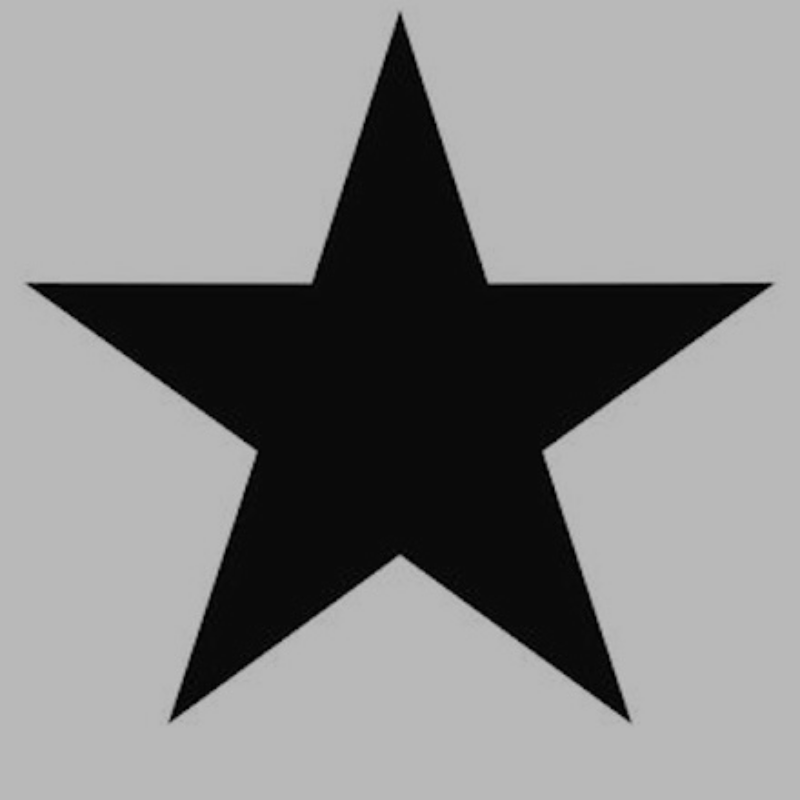

In [4]:
def readImage(filename, S=800):
    with open(filename, "rb") as f:
        image_bytes = f.read()
    image_tensor = torchvision.io.decode_image(torch.tensor(list(image_bytes)).byte(), mode=torchvision.io.ImageReadMode.GRAY)

    image_tensor = 1 - image_tensor.float() / 255.0
    resize_transform = torchvision.transforms.Resize( (S,S) )
    return resize_transform(image_tensor).squeeze()

def showImage(I):
    return torchvision.transforms.functional.to_pil_image( (1-I).clamp(0,1) )

target = readImage('knit/star.jpg')
# target = readImage('knit/circles.jpg')
# target = readImage('knit/world.jpg')
# target = readImage('knit/eye.jpg')
showImage(target)

### Key helper functions

Our decision variables are the number of threads between each pair of pegs. We need a way to visualize how we've done, and also to compute in a quantitative (and differentiable!) way how well we're doing. That means that we need to map our decision variables to pixel intensities.



In [5]:
N = 200
S = target.shape[0]
R = S//2
i, j = torch.meshgrid(torch.arange(-R, R), torch.arange(-R, R), indexing="ij")
mask = (i**2 + j**2) <= R**2 # we keep only a circular region of the image
points = torch.stack((i[mask], j[mask]), dim=-1).float()
angles = torch.arange(N, dtype=torch.float32) * torch.pi / N
rotated_points = points @ torch.stack([torch.cos(angles), -torch.sin(angles)])
rotated_points_line = N * (rotated_points / R).arccos() / torch.pi - (torch.arange(N) % 2)
closest_line = torch.round(rotated_points_line / 2).clamp(0,N//2-1).int()
rows = torch.stack(
    [R * ( (2*torch.arange(N//2) + 0)  * torch.pi / N).cos(),
     R * ( (2*torch.arange(N//2) + 1)  * torch.pi / N).cos()], 1
)

def linesToImage(lines):
    device = lines.device
    idxN = torch.arange(N, device=device)
    L = lines[closest_line, idxN].clamp(0,1)
    L *= torch.abs( rotated_points - rows[ closest_line, idxN % 2 ] ) <= 1
    I = torch.zeros((S,S), device=device)
    I[mask] = L.sum(-1)
    return I

In [6]:
# everything to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

target = target.to(device)
i, j = i.to(device), j.to(device)
mask = mask.to(device)
points = points.to(device)
angles = angles.to(device)
rotated_points = rotated_points.to(device)
rotated_points_line = rotated_points_line.to(device)
closest_line = closest_line.to(device)
rows = rows.to(device)

In [7]:
# initialize
lines = torch.zeros((N//2, N), device=device, requires_grad=True)

### TO DO

Now you have the tools you need. Your decision variables are contained in ``lines``. You have a way to compute the image that your current instanteation of ``lines`` produces:

```
pred = linesToImage(lines)
```

You can then use this to compute how far you are in MSE from the target:

```
loss = ((pred[mask] - target[mask]) ** 2).mean()
```

Now you can use some gradient descent (or any flavor you like, such as ADAM), by computing the gradient of the loss (``loss.backward()``), and then taking a gradient step (``optimizer.step()``).

Note: do not worry about negative or fractional weights for the number of threads from peg to peg -- it we wanted to interpret this as an actually realizable thread-art design, we could do so using scaling.

Iteration 100/1000, Loss: 0.027460
Iteration 200/1000, Loss: 0.027458
Iteration 300/1000, Loss: 0.027458
Iteration 400/1000, Loss: 0.027458
Iteration 500/1000, Loss: 0.027458
Iteration 600/1000, Loss: 0.027458
Iteration 700/1000, Loss: 0.027458
Iteration 800/1000, Loss: 0.027458
Iteration 900/1000, Loss: 0.027458
Iteration 1000/1000, Loss: 0.027458
Final Loss: 0.027458


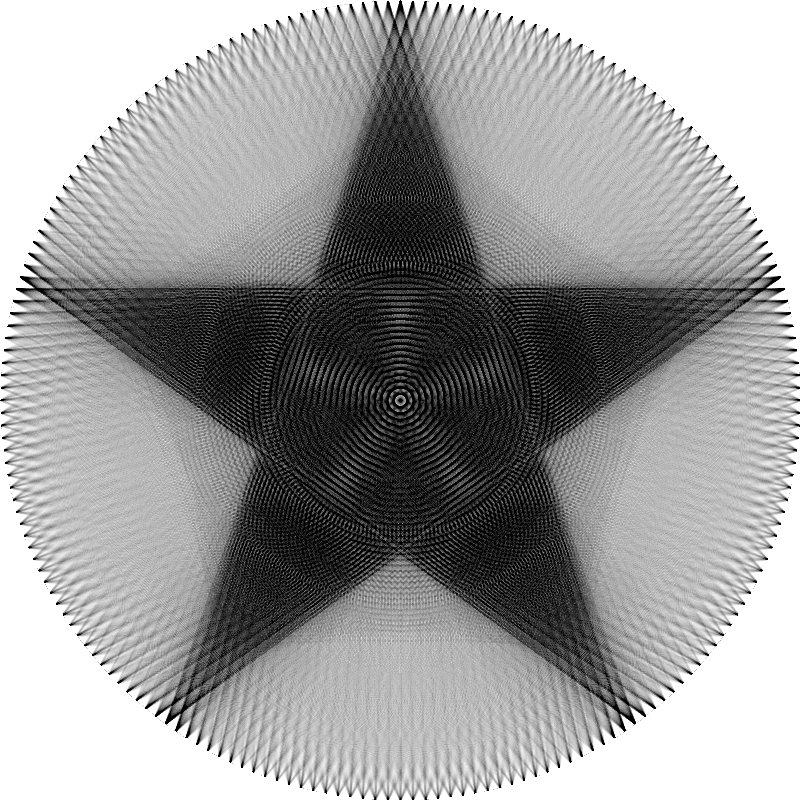

In [9]:
lines = (0.01*torch.rand((N//2, N), device=device)).requires_grad_()

# Create optimizer
optimizer = torch.optim.Adam([lines], lr=0.005, eps=1e-8)

# Training parameters
num_iterations = 1000
print_every = 100

# Training loop
for iteration in range(num_iterations):
    optimizer.zero_grad()

    # Forward pass: generate image from thread configuration
    pred = linesToImage(lines)

    # Compute MSE loss
    loss = ((pred[mask] - target[mask]) ** 2).mean()

    # Backward pass
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Print progress
    if (iteration + 1) % print_every == 0:
        print(f"Iteration {iteration + 1}/{num_iterations}, Loss: {loss.item():.6f}")

print(f"Final Loss: {loss.item():.6f}")

showImage(pred.detach())

## Problem 2 (Optional)

Do this for color images either by using colorful thread (thread of any color that is a superposition of RGB), or by using R or G or B threads.

## Problem 3

In this exercise, you will verify that cats and dogs from CIFAR-10 are not separable in pixel space. Then you will show that they are (nearly) separable once you pass them through all but the last layers of a neural network like ``resnet18`` that gets high accuracy on CIFAR-10. [The notebook I posted](https://colab.research.google.com/drive/1g6U_A3N62vstw5eFHE3vbzoq3_jiZmma?usp=drive_link) on transfer learning and CIFAR-10 will be very useful here, as our starting point is a well-trained ``restnet18``.

**Part 1**: Download CIFAR-10. Extract just the dogs and the cats and form data loaders. Train a neural network with a single linear layer (``nn.linear(3072,2)``) and plot the final **training** loss and accuracy (this is not a problem of train vs test -- we are interested in exploring the geometric structure of the training data).

Report the final loss and accuracy that you get. What does this tell us about the data points in pixel space?

**Part 2**: Pass all the data through the first n-1 layers of ``resnet18``. Now you will have a dataset of about 10,000 512-dimensional points.

**Part 3**: Train a neural network with a single linear layer on these data. Now how well do you do?

**Part 4**: In class, I showed you a 2-dimensional plot with (most) dogs on one side, and (most) cats on the other. Try to find a two dimensional projection of the data you generated in Part 2, that looks similar.

In [10]:
# Problem 3: Setup and Data Preparation

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transforms for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Download CIFAR-10
train_dataset_full = datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)
test_dataset_full = datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)

# CIFAR-10 classes: [0:airplane, 1:automobile, 2:bird, 3:cat, 4:deer, 5:dog, 6:frog, 7:horse, 8:ship, 9:truck]
CAT_CLASS = 3
DOG_CLASS = 5

# Extract only cats and dogs
train_cat_dog_indices = [i for i, (_, label) in enumerate(train_dataset_full) if label in [CAT_CLASS, DOG_CLASS]]
test_cat_dog_indices = [i for i, (_, label) in enumerate(test_dataset_full) if label in [CAT_CLASS, DOG_CLASS]]

train_dataset = Subset(train_dataset_full, train_cat_dog_indices)
test_dataset = Subset(test_dataset_full, test_cat_dog_indices)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Using device: cuda


100%|██████████| 170M/170M [00:06<00:00, 27.6MB/s]


Training samples: 10000
Test samples: 2000


Epoch 5/20, Loss: 0.713641, Accuracy: 0.6032
Epoch 10/20, Loss: 0.696406, Accuracy: 0.6095
Epoch 15/20, Loss: 0.707989, Accuracy: 0.6192
Epoch 20/20, Loss: 0.678981, Accuracy: 0.6303

Part 1 Results (Pixel Space):
Final Training Loss: 0.678981
Final Training Accuracy: 0.6303
This shows that cats and dogs are NOT separable in raw pixel space!


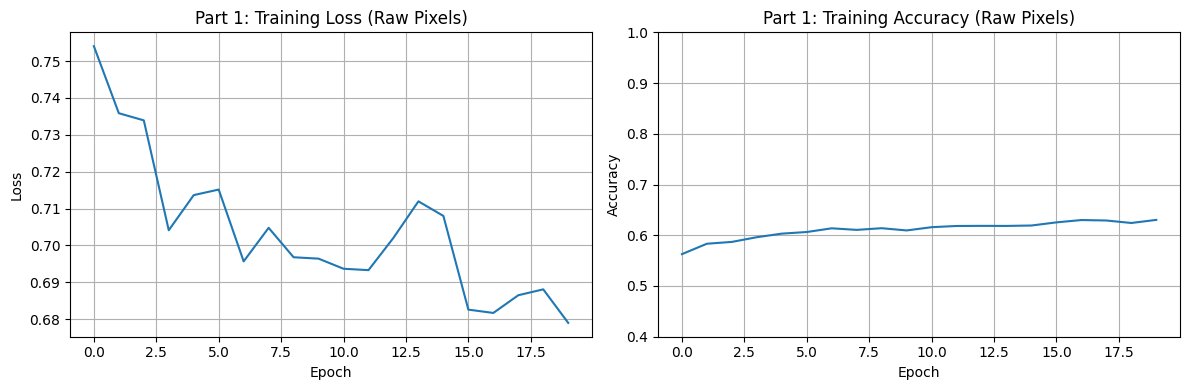

In [11]:
# Part 1: Build and train linear classifier on pixel space
class SimpleLinearModel(nn.Module):
    def __init__(self, input_size=3072, num_classes=2):
        super(SimpleLinearModel, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

# Initialize model
model_pixel = SimpleLinearModel(input_size=3072, num_classes=2).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_pixel = optim.Adam(model_pixel.parameters(), lr=0.001)

# Training loop
epochs = 20
train_losses_pixel = []
train_accuracies_pixel = []

for epoch in range(epochs):
    model_pixel.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # Convert labels: cat=3 -> 0, dog=5 -> 1
        labels = (labels == DOG_CLASS).long()

        optimizer_pixel.zero_grad()
        outputs = model_pixel(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_pixel.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    train_losses_pixel.append(avg_loss)
    train_accuracies_pixel.append(accuracy)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}, Accuracy: {accuracy:.4f}")

print(f"\nPart 1 Results (Pixel Space):")
print(f"Final Training Loss: {train_losses_pixel[-1]:.6f}")
print(f"Final Training Accuracy: {train_accuracies_pixel[-1]:.4f}")
print("This shows that cats and dogs are NOT separable in raw pixel space!")

# Plot Part 1 results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_pixel)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Part 1: Training Loss (Raw Pixels)')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_pixel)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Part 1: Training Accuracy (Raw Pixels)')
plt.ylim([0.4, 1.0])
plt.grid()
plt.tight_layout()
plt.show()


In [12]:
# Part 2: Extract features from ResNet-18
# Load pre-trained ResNet-18
resnet = models.resnet18(pretrained=True)
resnet = resnet.to(device)
resnet.eval()

# Resize transform for ResNet (needs 224x224)
transform_resnet = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create datasets with resized images
train_dataset_resnet = datasets.CIFAR10(root='./data', train=True,
                                         download=True, transform=transform_resnet)
train_dataset_resnet = Subset(train_dataset_resnet, train_cat_dog_indices)

# Create feature extractor (remove final layer)
class FeatureExtractor(nn.Module):
    def __init__(self, resnet):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC layer

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 512)
        return x

feature_extractor = FeatureExtractor(resnet).to(device)

# Extract features for all training data
train_features = []
train_labels_embedded = []

with torch.no_grad():
    for images, labels in DataLoader(train_dataset_resnet, batch_size=batch_size, shuffle=False):
        images = images.to(device)
        features = feature_extractor(images)
        train_features.append(features.cpu())
        # Convert labels: cat=3 -> 0, dog=5 -> 1
        labels = (labels == DOG_CLASS).long()
        train_labels_embedded.append(labels)

# Concatenate all features
train_features = torch.cat(train_features, dim=0)
train_labels_embedded = torch.cat(train_labels_embedded, dim=0)

print(f"\nPart 2 Results (Embedded Space):")
print(f"Feature dimensions: {train_features.shape}")  # Should be (N, 512)
print(f"Number of samples: {train_features.shape[0]}")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 211MB/s]



Part 2 Results (Embedded Space):
Feature dimensions: torch.Size([10000, 512])
Number of samples: 10000


Epoch 5/20, Loss: 0.263258, Accuracy: 0.8863
Epoch 10/20, Loss: 0.252377, Accuracy: 0.8902
Epoch 15/20, Loss: 0.241169, Accuracy: 0.8961
Epoch 20/20, Loss: 0.238778, Accuracy: 0.8970

Part 3 Results (Embedded Space):
Final Training Loss: 0.238778
Final Training Accuracy: 0.8970
Notice how much better we do in the embedded space!


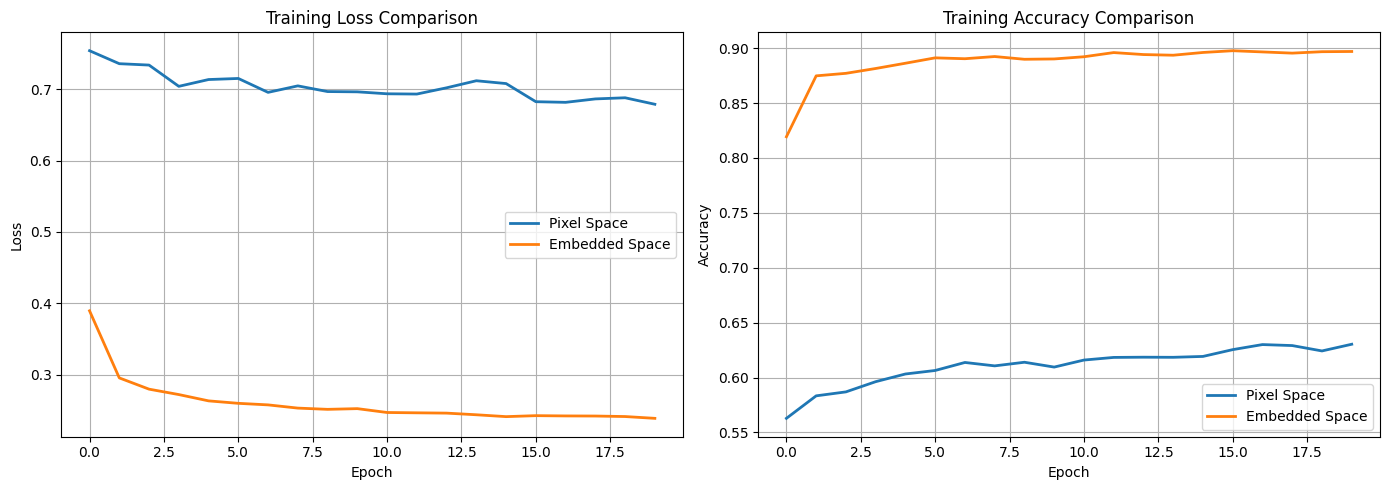

In [13]:
# Part 3: Train linear layer on embedded features
model_embedded = SimpleLinearModel(input_size=512, num_classes=2).to(device)

# Loss and optimizer
optimizer_embedded = optim.Adam(model_embedded.parameters(), lr=0.001)

# Create a simple dataset from pre-extracted features
class EmbeddedDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

embedded_dataset = EmbeddedDataset(train_features, train_labels_embedded)
embedded_loader = DataLoader(embedded_dataset, batch_size=batch_size, shuffle=True)

# Training loop
epochs = 20
train_losses_embedded = []
train_accuracies_embedded = []

for epoch in range(epochs):
    model_embedded.train()
    total_loss = 0
    correct = 0
    total = 0

    for features, labels in embedded_loader:
        features, labels = features.to(device), labels.to(device)

        optimizer_embedded.zero_grad()
        outputs = model_embedded(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_embedded.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(embedded_loader)
    accuracy = correct / total
    train_losses_embedded.append(avg_loss)
    train_accuracies_embedded.append(accuracy)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}, Accuracy: {accuracy:.4f}")

print(f"\nPart 3 Results (Embedded Space):")
print(f"Final Training Loss: {train_losses_embedded[-1]:.6f}")
print(f"Final Training Accuracy: {train_accuracies_embedded[-1]:.4f}")
print("Notice how much better we do in the embedded space!")

# Comparison plot
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_pixel, label='Pixel Space', linewidth=2)
plt.plot(train_losses_embedded, label='Embedded Space', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_pixel, label='Pixel Space', linewidth=2)
plt.plot(train_accuracies_embedded, label='Embedded Space', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



Part 4 Visualization:
Explained variance ratio: [0.05776652 0.04892402]
Total variance explained: 0.1067


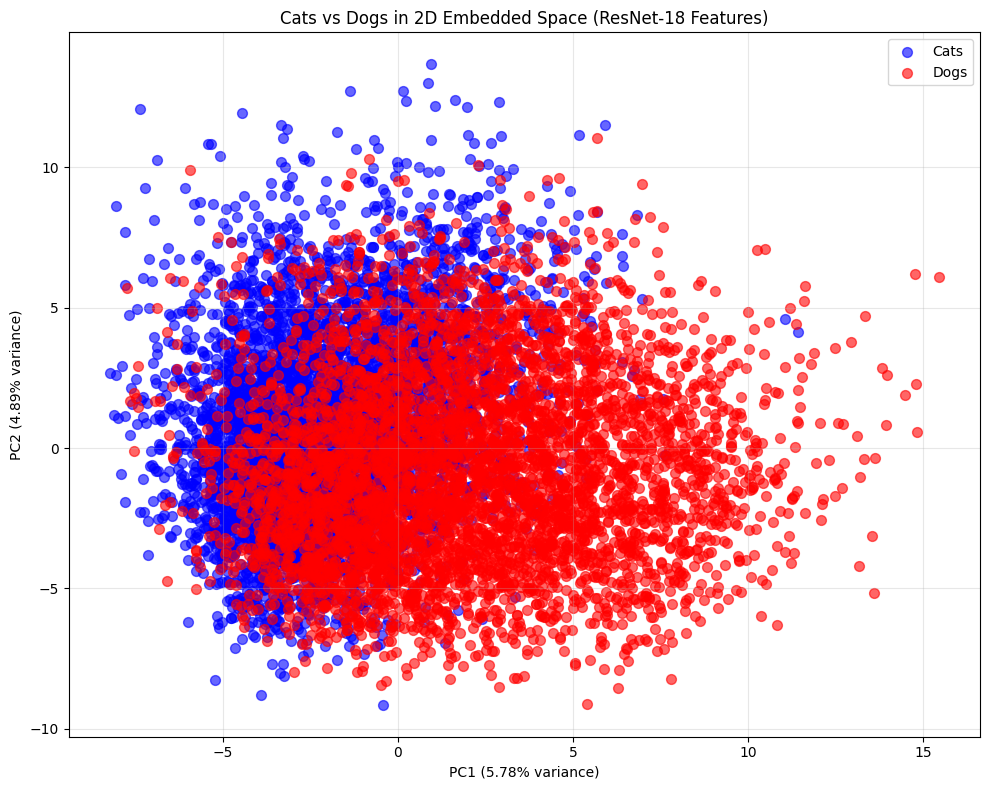


PROBLEM 3 SUMMARY
Part 1 (Pixel Space):
  - Accuracy: 0.6303
  - Loss: 0.678981
  - Conclusion: Cats and dogs are NOT linearly separable in pixel space

Part 2 (ResNet Feature Extraction):
  - Extracted 512-dimensional features for 10000 samples

Part 3 (Embedded Space):
  - Accuracy: 0.8970
  - Loss: 0.238778
  - Improvement: 0.2667
  - Conclusion: Cats and dogs ARE nearly linearly separable in ResNet embedded space!

Part 4:
  - 2D projection shows clear separation between cats and dogs
  - This demonstrates the power of learned embeddings for representation


In [14]:
# Part 4: 2D Visualization using PCA
# Apply PCA to reduce 512-dimensional features to 2D
pca = PCA(n_components=2)
features_2d = pca.fit_transform(train_features.numpy())

print(f"\nPart 4 Visualization:")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")

# Create visualization
plt.figure(figsize=(10, 8))

# Plot cats (label=0)
cats_mask = train_labels_embedded.numpy() == 0
plt.scatter(features_2d[cats_mask, 0], features_2d[cats_mask, 1],
           c='blue', alpha=0.6, s=50, label='Cats')

# Plot dogs (label=1)
dogs_mask = train_labels_embedded.numpy() == 1
plt.scatter(features_2d[dogs_mask, 0], features_2d[dogs_mask, 1],
           c='red', alpha=0.6, s=50, label='Dogs')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Cats vs Dogs in 2D Embedded Space (ResNet-18 Features)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Summary
print("\n" + "="*60)
print("PROBLEM 3 SUMMARY")
print("="*60)
print(f"Part 1 (Pixel Space):")
print(f"  - Accuracy: {train_accuracies_pixel[-1]:.4f}")
print(f"  - Loss: {train_losses_pixel[-1]:.6f}")
print(f"  - Conclusion: Cats and dogs are NOT linearly separable in pixel space\n")

print(f"Part 2 (ResNet Feature Extraction):")
print(f"  - Extracted 512-dimensional features for {train_features.shape[0]} samples\n")

print(f"Part 3 (Embedded Space):")
print(f"  - Accuracy: {train_accuracies_embedded[-1]:.4f}")
print(f"  - Loss: {train_losses_embedded[-1]:.6f}")
print(f"  - Improvement: {(train_accuracies_embedded[-1] - train_accuracies_pixel[-1]):.4f}")
print(f"  - Conclusion: Cats and dogs ARE nearly linearly separable in ResNet embedded space!\n")

print(f"Part 4:")
print(f"  - 2D projection shows clear separation between cats and dogs")
print(f"  - This demonstrates the power of learned embeddings for representation")
print("="*60)
